In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import optuna 
import math
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [2]:
adidas_final_df = pd.read_csv('adidas_final_df.csv')
text_df_256 = pd.read_csv('text_df_256.csv')

img_vgg16_256_df = pd.read_csv('img_vgg16_256_df.csv')
img_vgg19_256_df = pd.read_csv('img_vgg19_256_df.csv')
img_resnet50_256_df = pd.read_csv('img_resnet50_256_df.csv')
img_xception_256_df = pd.read_csv('img_xception_256_df.csv')

In [9]:
adidas_final_df = adidas_final_df.iloc[:, 1:]

text_df_256 = text_df_256.iloc[:, 1:]
text_df_256.columns = list('text' + str(i) for i in range(len(text_df_256.columns)))

img_vgg16_256_df = img_vgg16_256_df.iloc[:, 1:]
img_vgg16_256_df.columns = list('img' + str(i) for i in range(len(img_vgg16_256_df.columns)))

img_vgg19_256_df = img_vgg19_256_df.iloc[:, 1:]
img_vgg19_256_df.columns = list('img' + str(i) for i in range(len(img_vgg19_256_df.columns)))

img_resnet50_256_df = img_resnet50_256_df.iloc[:, 1:]
img_resnet50_256_df.columns = list('img' + str(i) for i in range(len(img_resnet50_256_df.columns)))

img_xception_256_df = img_xception_256_df.iloc[:, 1:]
img_xception_256_df.columns = list('img' + str(i) for i in range(len(img_xception_256_df.columns)))


img_vgg16_256_df = pd.concat([adidas_final_df[['retail_price', 'avg_sale_price_12_month']], img_vgg16_256_df, text_df_256], axis=1)
img_vgg19_256_df = pd.concat([adidas_final_df[['retail_price', 'avg_sale_price_12_month']], img_vgg19_256_df, text_df_256], axis=1)
img_resnet50_256_df = pd.concat([adidas_final_df[['retail_price', 'avg_sale_price_12_month']], img_resnet50_256_df, text_df_256], axis=1)
img_xception_256_df = pd.concat([adidas_final_df[['retail_price', 'avg_sale_price_12_month']], img_xception_256_df, text_df_256], axis=1)


[10:52:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:20333.7	eval-rmse:16320.7
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:16810.3	eval-rmse:14306.5
[2]	train-rmse:14372.8	eval-rmse:13143.2
[3]	train-rmse:12458.7	eval-rmse:12682.7
[4]	train-rmse:11048.6	eval-rmse:12247.5
[5]	train-rmse:9963.23	eval-rmse:11738.6
[6]	train-rmse:9211.95	eval-rmse:11709.4
[7]	train-rmse:8589.09	eval-rmse:11689
[8]	train-rmse:8070.53	eval-rmse:11695.7
[9]	train-rmse:7636.56	eval-rmse:11565.8
[10]	train-rmse:7409.37	eval-rmse:11564.8
[11]	train-rmse:7087.79	eval-rmse:11618.4
[12]	train-rmse:6817.04	eval-rmse:11633
[13]	train-rmse:6603.32	eval-rmse:11607.6
[14]	train-rmse:6399.9	eval-rmse:11653.9
[15]	train-rmse:6180.62	eval-rmse:11682.8
[16]	train-rmse:5988.19	eval-rmse:11702.4
[17]	train-rmse:5821.09	eval-rmse:11730.5


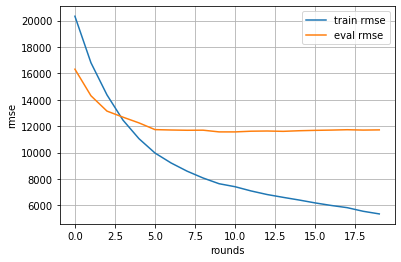

In [12]:
X = img_vgg16_256_df.drop('avg_sale_price_12_month', axis=1)
y = img_vgg16_256_df['avg_sale_price_12_month']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    # 回帰問題 reg:squarederror
    'objective': 'reg:linear',
    # 学習用の指標 (RMSE)
    'eval_metric': 'rmse',
}
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=1000,
                early_stopping_rounds=10,
                evals=evals,
                evals_result=evals_result,
                )

y_pred = bst.predict(dtest)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

[10:52:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:20551.7	eval-rmse:16196.5
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:17049.1	eval-rmse:13751.1
[2]	train-rmse:14658.6	eval-rmse:12640.8
[3]	train-rmse:12820.2	eval-rmse:11976.4
[4]	train-rmse:11368.3	eval-rmse:11778.1
[5]	train-rmse:10390.2	eval-rmse:11596.2
[6]	train-rmse:9625.67	eval-rmse:11581.5
[7]	train-rmse:9012.42	eval-rmse:11563.9
[8]	train-rmse:8561.02	eval-rmse:11636.3
[9]	train-rmse:8237.6	eval-rmse:11583.5
[10]	train-rmse:7866.25	eval-rmse:11589.7
[11]	train-rmse:7436.31	eval-rmse:11638.5
[12]	train-rmse:7113.1	eval-rmse:11632.9
[13]	train-rmse:6916.43	eval-rmse:11571
[14]	train-rmse:6639.7	eval-rmse:11564.2
[15]	train-rmse:6398.76	eval-rmse:11584.6
[16]	train-rmse:6245.09	eval-rmse:11624.2
[17]	train-rmse:6039.45	eval-rmse:11588.3


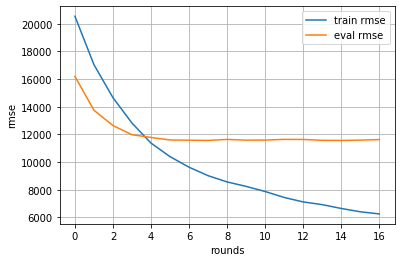

In [13]:
X = img_vgg19_256_df.drop('avg_sale_price_12_month', axis=1)
y = img_vgg19_256_df['avg_sale_price_12_month']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    # 回帰問題 reg:squarederror
    'objective': 'reg:linear',
    # 学習用の指標 (RMSE)
    'eval_metric': 'rmse',
}
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=1000,
                early_stopping_rounds=10,
                evals=evals,
                evals_result=evals_result,
                )

y_pred = bst.predict(dtest)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

[10:53:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:20575.6	eval-rmse:16006
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:17136.2	eval-rmse:13897
[2]	train-rmse:14706	eval-rmse:12673.1
[3]	train-rmse:12916.9	eval-rmse:12080.1
[4]	train-rmse:11419.4	eval-rmse:11741.4
[5]	train-rmse:10403.7	eval-rmse:11679.3
[6]	train-rmse:9644.45	eval-rmse:11593.9
[7]	train-rmse:9108.9	eval-rmse:11573.5
[8]	train-rmse:8601.02	eval-rmse:11587.1
[9]	train-rmse:8124.78	eval-rmse:11579.6
[10]	train-rmse:7704.12	eval-rmse:11587.5
[11]	train-rmse:7379.58	eval-rmse:11604.9
[12]	train-rmse:7061.77	eval-rmse:11594.8
[13]	train-rmse:6894.03	eval-rmse:11627.8
[14]	train-rmse:6709.6	eval-rmse:11656
[15]	train-rmse:6443.34	eval-rmse:11697.6
[16]	train-rmse:6153.67	eval-rmse:11745.7
[17]	train-rmse:5857.71	eval-rmse:11792.9
Stopp

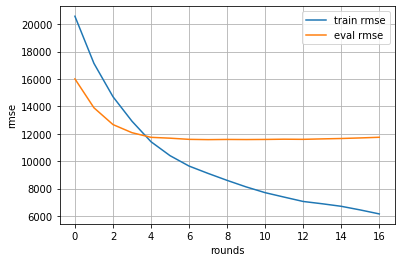

In [14]:
X = img_resnet50_256_df.drop('avg_sale_price_12_month', axis=1)
y = img_resnet50_256_df['avg_sale_price_12_month']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    # 回帰問題 reg:squarederror
    'objective': 'reg:linear',
    # 学習用の指標 (RMSE)
    'eval_metric': 'rmse',
}
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=1000,
                early_stopping_rounds=10,
                evals=evals,
                evals_result=evals_result,
                )

y_pred = bst.predict(dtest)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

[10:53:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:20485.6	eval-rmse:16114.7
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:17086.8	eval-rmse:13884.5
[2]	train-rmse:14563.8	eval-rmse:12646.6
[3]	train-rmse:12741.3	eval-rmse:12031.3
[4]	train-rmse:11285.2	eval-rmse:11735.4
[5]	train-rmse:10233.5	eval-rmse:11289.2
[6]	train-rmse:9414.84	eval-rmse:11231.7
[7]	train-rmse:8847.74	eval-rmse:11269.8
[8]	train-rmse:8405.16	eval-rmse:11285.8
[9]	train-rmse:8019.23	eval-rmse:11331.7
[10]	train-rmse:7761.33	eval-rmse:11337.4
[11]	train-rmse:7560.47	eval-rmse:11381.1
[12]	train-rmse:7225.11	eval-rmse:11378.9
[13]	train-rmse:6965.23	eval-rmse:11374
[14]	train-rmse:6744.05	eval-rmse:11431.2
[15]	train-rmse:6449.74	eval-rmse:11436.8
[16]	train-rmse:6308.6	eval-rmse:11449
Stopping. Best iteration:
[6]	train-rmse:9

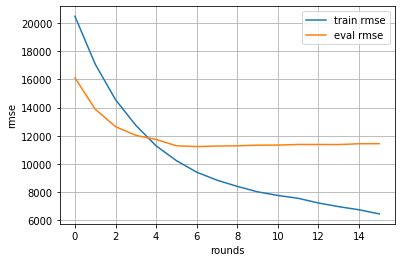

In [15]:
X = img_xception_256_df.drop('avg_sale_price_12_month', axis=1)
y = img_xception_256_df['avg_sale_price_12_month']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    # 回帰問題 reg:squarederror
    'objective': 'reg:linear',
    # 学習用の指標 (RMSE)
    'eval_metric': 'rmse',
}
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=1000,
                early_stopping_rounds=10,
                evals=evals,
                evals_result=evals_result,
                )

y_pred = bst.predict(dtest)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()